# Optuna

*   Website: https://optuna.org/
*   Docs: https://optuna.readthedocs.io/en/stable/index.html
*   Github: https://github.com/optuna/optuna
*   Article: https://arxiv.org/abs/1907.10902

## Optuna –Search algorithms

*    Grid Search
*    Random Search
*    Tree-structured Parzen Estimators (TPE)
*    CMA-ES
*    Multi-objective sampler using the NSGA-II algorithm
*    Multi-objective sampler using the MOTPE algorithm

## Optuna –objective function

Objective function created by user

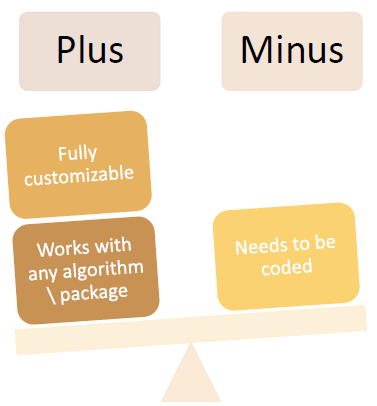

## Optuna –Distributions

*   Samples Reals, Integers and Categories
*   Uniform and Log-Uniform distributions
*   Define-by-run API -> Nested spaces

## Optuna –Acquisition Function

*    Uses function described in original work that introduced each algorithm.
*    We can’t choose which function to use
*    Expected Improvement (EI)
*    Expected hypervolume improvement (EHVI)

## Optuna –Search analysis

*   Can store the search in a SQL like DB
*   Study object returns a dataframe with search data
*   Built-in functions for plotting

## Parallelization -SQLite

*   Allows search in parallel storing in SQL like database
    *   Reduced efficiency per (single) evaluation
    *   Increased overall efficiency by saving time

## Optuna –Main setup

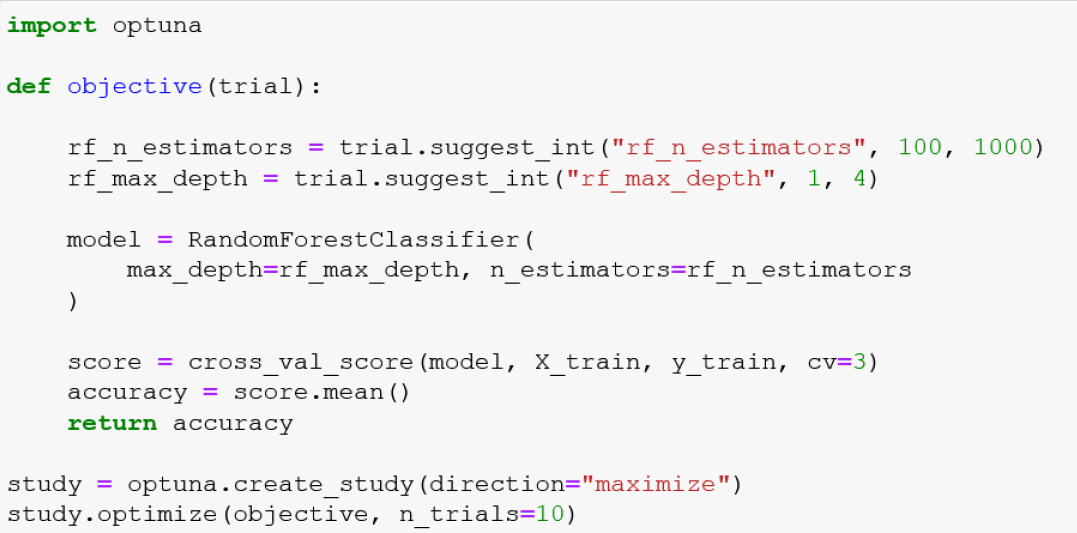

### Optuna –create_study

[optuna.create_study()](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.create_study.html#optuna.study.create_study-Parameters)
*   storage: url to a database
*   sampler: the hyperparameter search algorithm (defo: tpe)
*   pruner: the algorithm to prune unsuccessful trials (defo: MedianPruner)
*   direction: ‘minimize’ or ‘maximize’
*   study_name: name for the study, in case saved and retrieved later

### Optuna -sampler

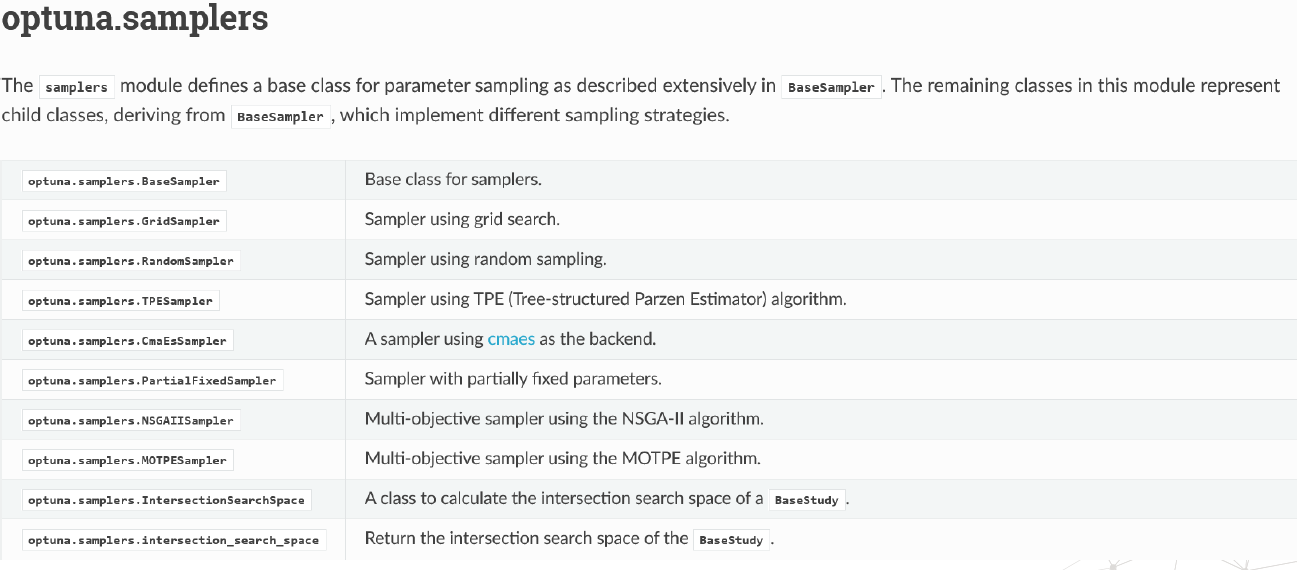

### Optuna -pruner

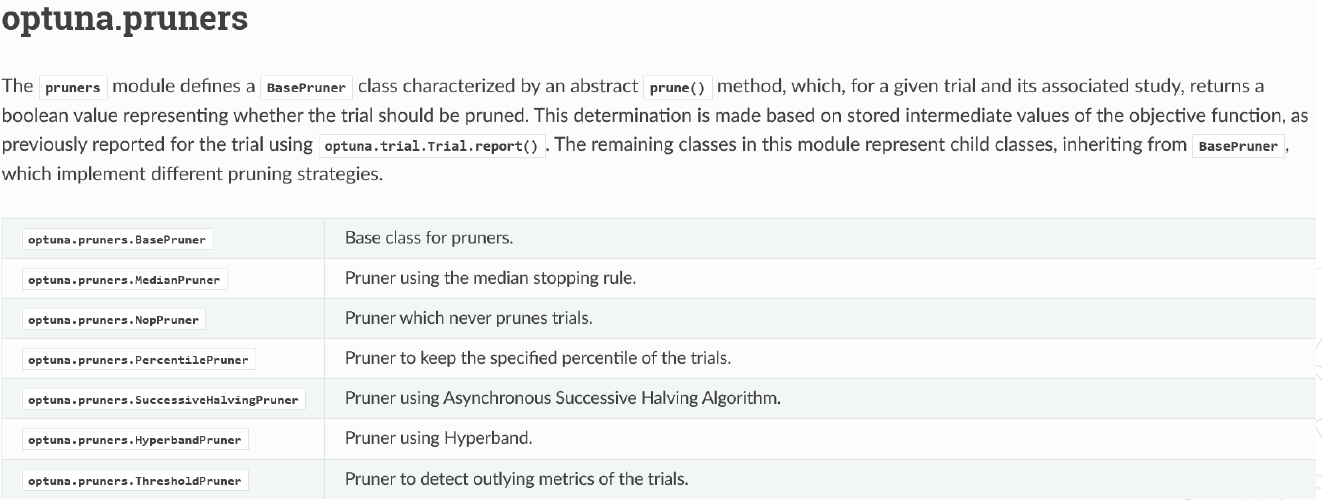

### Optuna –trials

[optuna.trial.Trials()](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial)

Used under the hood by optuna.study.Study.optimize()

We only need the below for the objective function

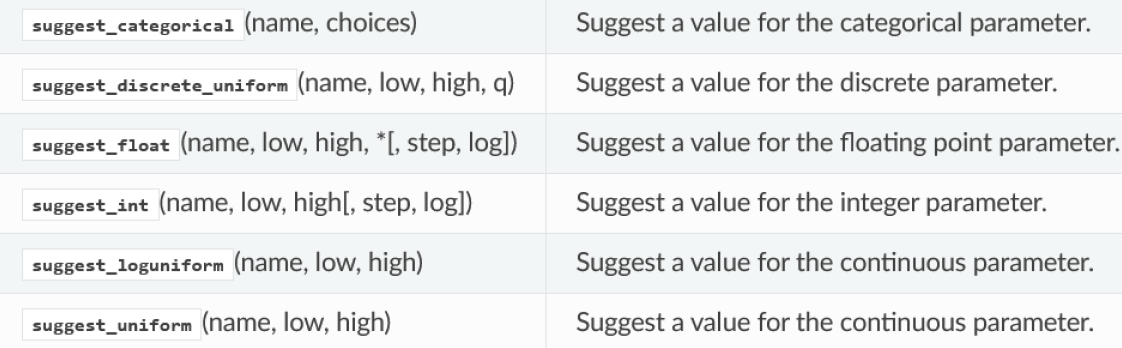

## Implementation

### Search algorithms within Optuna

I will demo how to select the search algorithm with Optuna. We will compare the use of:

- Grid Search 
- Randomized search
- Tree-structured Parzen Estimators
- CMA-ES


We can select the search algorithm from the [optuna.study.create_study()](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.create_study.html#optuna.study.create_study) class.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier

import optuna

In [ ]:
# load dataset

breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})

X.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
# the target:
# percentage of benign (0) and malign tumors (1)

y.value_counts() / len(y)

0    0.627417
1    0.372583
dtype: float64

In [ ]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((398, 30), (171, 30))

#### Define the objective function

This is the hyperparameter response space, the function we want to minimize.

In [ ]:
# the objective function takes the hyperparameter space
# as input

def objective(trial):

    rf_n_estimators = trial.suggest_int("rf_n_estimators", 100, 1000)
    rf_criterion = trial.suggest_categorical("rf_criterion", ['gini', 'entropy'])
    rf_max_depth = trial.suggest_int("rf_max_depth", 1, 4)
    rf_min_samples_split = trial.suggest_float("rf_min_samples_split", 0.01, 1)
    
    model = RandomForestClassifier(
        n_estimators=rf_n_estimators,
        criterion=rf_criterion,
        max_depth=rf_max_depth,
        min_samples_split=rf_min_samples_split,
    )

    score = cross_val_score(model, X_train, y_train, cv=3)
    accuracy = score.mean()
    return accuracy

#### Randomized Search

RandomSampler()

In [ ]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.RandomSampler(),
)


study.optimize(objective, n_trials=5)

[I 2021-05-20 13:32:32,020] A new study created in memory with name: no-name-4c05d223-a14c-42e4-8d41-4e85e52a2f1b
[I 2021-05-20 13:32:36,656] Trial 0 finished with value: 0.6256360598465861 and parameters: {'rf_n_estimators': 695, 'rf_criterion': 'entropy', 'rf_max_depth': 2, 'rf_min_samples_split': 0.8783579308131435}. Best is trial 0 with value: 0.6256360598465861.
[I 2021-05-20 13:32:39,777] Trial 1 finished with value: 0.6256360598465861 and parameters: {'rf_n_estimators': 605, 'rf_criterion': 'entropy', 'rf_max_depth': 1, 'rf_min_samples_split': 0.9699877119978241}. Best is trial 0 with value: 0.6256360598465861.
[I 2021-05-20 13:32:42,322] Trial 2 finished with value: 0.937210450368345 and parameters: {'rf_n_estimators': 424, 'rf_criterion': 'gini', 'rf_max_depth': 3, 'rf_min_samples_split': 0.10419683337955472}. Best is trial 2 with value: 0.937210450368345.
[I 2021-05-20 13:32:43,359] Trial 3 finished with value: 0.6256360598465861 and parameters: {'rf_n_estimators': 210, 'rf_c

In [ ]:
study.best_params

{'rf_n_estimators': 424,
 'rf_criterion': 'gini',
 'rf_max_depth': 3,
 'rf_min_samples_split': 0.10419683337955472}

In [ ]:
study.best_value

0.937210450368345

In [ ]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_rf_criterion,params_rf_max_depth,params_rf_min_samples_split,params_rf_n_estimators,state
0,0,0.625636,2021-05-20 13:32:32.042563,2021-05-20 13:32:36.656177,0 days 00:00:04.613614,entropy,2,0.878358,695,COMPLETE
1,1,0.625636,2021-05-20 13:32:36.657176,2021-05-20 13:32:39.777438,0 days 00:00:03.120262,entropy,1,0.969988,605,COMPLETE
2,2,0.937210,2021-05-20 13:32:39.778938,2021-05-20 13:32:42.321280,0 days 00:00:02.542342,gini,3,0.104197,424,COMPLETE
3,3,0.625636,2021-05-20 13:32:42.323279,2021-05-20 13:32:43.359032,0 days 00:00:01.035753,gini,3,0.747577,210,COMPLETE
4,4,0.625636,2021-05-20 13:32:43.359953,2021-05-20 13:32:45.300349,0 days 00:00:01.940396,gini,3,0.857621,445,COMPLETE


#### TPE

TPESampler is the default

In [ ]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
)


study.optimize(objective, n_trials=5)

[I 2021-05-20 13:32:45,354] A new study created in memory with name: no-name-2f472476-1aa4-41b3-b983-9128993bfd6e
[I 2021-05-20 13:32:46,964] Trial 0 finished with value: 0.9171033644717855 and parameters: {'rf_n_estimators': 301, 'rf_criterion': 'entropy', 'rf_max_depth': 1, 'rf_min_samples_split': 0.14385722106431506}. Best is trial 0 with value: 0.9171033644717855.
[I 2021-05-20 13:32:50,692] Trial 1 finished with value: 0.9045720361509835 and parameters: {'rf_n_estimators': 743, 'rf_criterion': 'gini', 'rf_max_depth': 3, 'rf_min_samples_split': 0.6360216981020187}. Best is trial 0 with value: 0.9171033644717855.
[I 2021-05-20 13:32:52,094] Trial 2 finished with value: 0.6256360598465861 and parameters: {'rf_n_estimators': 287, 'rf_criterion': 'gini', 'rf_max_depth': 3, 'rf_min_samples_split': 0.7477125830084222}. Best is trial 0 with value: 0.9171033644717855.
[I 2021-05-20 13:32:53,322] Trial 3 finished with value: 0.9196286169970379 and parameters: {'rf_n_estimators': 258, 'rf_cr

In [ ]:
study.best_params

{'rf_n_estimators': 258,
 'rf_criterion': 'gini',
 'rf_max_depth': 1,
 'rf_min_samples_split': 0.02246294933654927}

In [ ]:
study.best_value

0.9196286169970379

#### CMA-ES

CmaEsSampler

In [ ]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.CmaEsSampler(),
)

study.optimize(objective, n_trials=5)

[I 2021-05-20 13:32:54,590] A new study created in memory with name: no-name-dc7be453-0f50-433f-892c-5c0a83309477
[I 2021-05-20 13:32:56,816] Trial 0 finished with value: 0.6256360598465861 and parameters: {'rf_n_estimators': 461, 'rf_criterion': 'entropy', 'rf_max_depth': 1, 'rf_min_samples_split': 0.8157876455065424}. Best is trial 0 with value: 0.6256360598465861.
[W 2021-05-20 13:32:56,820] The parameter 'rf_criterion' in trial#1 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[I 2021-05-20 13:33:00,973] Trial 1 finished with value: 0.9146160856687172 and parameters: {'rf_n_estimators': 550, 'rf_criterion': 'entropy', 'rf_max_depth': 2, 'rf_min_samples_split': 0.5

In [ ]:
study.best_params

{'rf_n_estimators': 550,
 'rf_criterion': 'gini',
 'rf_max_depth': 3,
 'rf_min_samples_split': 0.3532396490443734}

In [ ]:
study.best_value

0.9321219715956558

#### Grid Search

GridSampler()

We are probably not going to perform GridSearch with Optuna, but in case you wanted to, you need to add a variable with the space, with the exact values that you want to be tested.

In [ ]:
search_space = {
    "rf_n_estimators": [100, 500, 1000],
    "rf_criterion": ['gini', 'entropy'],
    "rf_max_depth": [1, 2, 3],
    "rf_min_samples_split": [0.1, 1.0]
}


In [ ]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.GridSampler(search_space),
)

study.optimize(objective)

[I 2021-05-20 13:33:09,736] A new study created in memory with name: no-name-8d361ba9-6448-4fd0-8b39-426d946d9651
[I 2021-05-20 13:33:13,906] Trial 0 finished with value: 0.6256360598465861 and parameters: {'rf_n_estimators': 1000, 'rf_criterion': 'gini', 'rf_max_depth': 3, 'rf_min_samples_split': 1.0}. Best is trial 0 with value: 0.6256360598465861.
[I 2021-05-20 13:33:14,420] Trial 1 finished with value: 0.9397357028935976 and parameters: {'rf_n_estimators': 100, 'rf_criterion': 'gini', 'rf_max_depth': 3, 'rf_min_samples_split': 0.1}. Best is trial 1 with value: 0.9397357028935976.
[I 2021-05-20 13:33:14,873] Trial 2 finished with value: 0.9045150755677072 and parameters: {'rf_n_estimators': 100, 'rf_criterion': 'gini', 'rf_max_depth': 1, 'rf_min_samples_split': 0.1}. Best is trial 1 with value: 0.9397357028935976.
[I 2021-05-20 13:33:19,585] Trial 3 finished with value: 0.937210450368345 and parameters: {'rf_n_estimators': 1000, 'rf_criterion': 'gini', 'rf_max_depth': 3, 'rf_min_sam

[I 2021-05-20 13:34:30,674] Trial 32 finished with value: 0.9397357028935976 and parameters: {'rf_n_estimators': 500, 'rf_criterion': 'gini', 'rf_max_depth': 3, 'rf_min_samples_split': 0.1}. Best is trial 29 with value: 0.9422609554188502.
[I 2021-05-20 13:34:33,339] Trial 33 finished with value: 0.942241968557758 and parameters: {'rf_n_estimators': 500, 'rf_criterion': 'entropy', 'rf_max_depth': 3, 'rf_min_samples_split': 0.1}. Best is trial 29 with value: 0.9422609554188502.
[I 2021-05-20 13:34:38,710] Trial 34 finished with value: 0.9397357028935976 and parameters: {'rf_n_estimators': 1000, 'rf_criterion': 'entropy', 'rf_max_depth': 3, 'rf_min_samples_split': 0.1}. Best is trial 29 with value: 0.9422609554188502.
[I 2021-05-20 13:34:39,144] Trial 35 finished with value: 0.6256360598465861 and parameters: {'rf_n_estimators': 100, 'rf_criterion': 'gini', 'rf_max_depth': 3, 'rf_min_samples_split': 1.0}. Best is trial 29 with value: 0.9422609554188502.


In [ ]:
study.best_params

{'rf_n_estimators': 100,
 'rf_criterion': 'gini',
 'rf_max_depth': 2,
 'rf_min_samples_split': 0.1}

In [ ]:
study.best_value

0.9422609554188502

### Tuning hyperparameters for different ML models

we will use the define-by-run framework to optimize the hyperparameters of various machine learning models from Scikit-learn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

import optuna

In [ ]:
# load dataset

breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})

X.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
# the target:
# percentage of benign (0) and malign tumors (1)

y.value_counts() / len(y)

0    0.627417
1    0.372583
dtype: float64

In [ ]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((398, 30), (171, 30))

#### Define the objective function

This is the hyperparameter response space, the function we want to optimize.

In [ ]:
# the objective function takes the hyperparameter space
# as input

def objective(trial):
    
    classifier_name = trial.suggest_categorical("classifier", ["logit", "RF", 'GBM'])
    
    if classifier_name == "logit":
        
        logit_penalty = trial.suggest_categorical('logit_penalty', ['l1','l2'])
        logit_c = trial.suggest_float('logit_c', 0.001, 10)
        logit_solver = 'saga'
        
        model = LogisticRegression(
            penalty=logit_penalty,
            C=logit_c,
            solver=logit_solver,
        )
        
    elif classifier_name =="RF":
        
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 100, 1000)
        rf_criterion = trial.suggest_categorical("rf_criterion", ['gini', 'entropy'])
        rf_max_depth = trial.suggest_int("rf_max_depth", 1, 4)
        rf_min_samples_split = trial.suggest_float("rf_min_samples_split", 0.01, 1)

        model = RandomForestClassifier(
            n_estimators=rf_n_estimators,
            criterion=rf_criterion,
            max_depth=rf_max_depth,
            min_samples_split=rf_min_samples_split,
        )
        
    else:
        
        gbm_n_estimators = trial.suggest_int("gbm_n_estimators", 100, 1000)
        gbm_criterion = trial.suggest_categorical("gbm_criterion", ['mse', 'friedman_mse'])
        gbm_max_depth = trial.suggest_int("gbm_max_depth", 1, 4)
        gbm_min_samples_split = trial.suggest_float("gbm_min_samples_split", 0.01, 1)

        model = GradientBoostingClassifier(
            n_estimators=gbm_n_estimators,
            criterion=gbm_criterion,
            max_depth=gbm_max_depth,
            min_samples_split=gbm_min_samples_split,
        )

    
    score = cross_val_score(model, X_train, y_train, cv=3)
    accuracy = score.mean()
    
    return accuracy

#### TPE

TPESampler is the default

In [ ]:
study = optuna.create_study(
    direction="maximize",
    # we do not need the below line, 
    # tpe is the default search
    sampler=optuna.samplers.TPESampler(),
)


study.optimize(objective, n_trials=20)

[I 2021-05-20 13:53:31,353] A new study created in memory with name: no-name-fbf66387-b401-442f-affd-75fd9ba26c9d
c:\users\sole\documents\repositories\envs\html\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\sole\documents\repositories\envs\html\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\sole\documents\repositories\envs\html\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[I 2021-05-20 13:53:31,434] Trial 0 finished with value: 0.9120148856990963 and parameters: {'classifier': 'logit', 'logit_penalty': 'l1', 'logit_c': 6.072657399731582}.

[I 2021-05-20 13:54:03,419] Trial 19 finished with value: 0.9623300675932255 and parameters: {'classifier': 'GBM', 'gbm_n_estimators': 567, 'gbm_criterion': 'mse', 'gbm_max_depth': 3, 'gbm_min_samples_split': 0.6447938949231241}. Best is trial 15 with value: 0.9698488645857067.


In [ ]:
study.best_params

{'classifier': 'GBM',
 'gbm_n_estimators': 301,
 'gbm_criterion': 'mse',
 'gbm_max_depth': 2,
 'gbm_min_samples_split': 0.7450851430645121}

In [ ]:
study.best_value

0.9698488645857067

In [ ]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_classifier,params_gbm_criterion,params_gbm_max_depth,params_gbm_min_samples_split,params_gbm_n_estimators,params_logit_c,params_logit_penalty,params_rf_criterion,params_rf_max_depth,params_rf_min_samples_split,params_rf_n_estimators,state
0,0,0.912015,2021-05-20 13:53:31.360491,2021-05-20 13:53:31.433543,0 days 00:00:00.073052,logit,NaN,NaN,NaN,NaN,6.072657,l1,NaN,NaN,NaN,NaN,COMPLETE
1,1,0.912015,2021-05-20 13:53:31.434544,2021-05-20 13:53:31.529611,0 days 00:00:00.095067,logit,NaN,NaN,NaN,NaN,7.331768,l1,NaN,NaN,NaN,NaN,COMPLETE
2,2,0.912015,2021-05-20 13:53:31.530710,2021-05-20 13:53:31.606316,0 days 00:00:00.075606,logit,NaN,NaN,NaN,NaN,7.617337,l1,NaN,NaN,NaN,NaN,COMPLETE
3,3,0.962311,2021-05-20 13:53:31.608011,2021-05-20 13:53:33.443316,0 days 00:00:01.835305,GBM,mse,2.0,0.260728,356.0,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
4,4,0.625636,2021-05-20 13:53:33.447319,2021-05-20 13:53:34.204855,0 days 00:00:00.757536,RF,NaN,NaN,NaN,NaN,NaN,NaN,gini,3.0,0.753918,145.0,COMPLETE
5,5,0.917122,2021-05-20 13:53:34.206857,2021-05-20 13:53:35.447736,0 days 00:00:01.240879,RF,NaN,NaN,NaN,NaN,NaN,NaN,gini,1.0,0.592372,267.0,COMPLETE
6,6,0.625636,2021-05-20 13:53:35.449738,2021-05-20 13:53:38.711194,0 days 00:00:03.261456,RF,NaN,NaN,NaN,NaN,NaN,NaN,entropy,4.0,0.894730,798.0,COMPLETE
7,7,0.947292,2021-05-20 13:53:38.712696,2021-05-20 13:53:42.948934,0 days 00:00:04.236238,GBM,mse,3.0,0.345416,710.0,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
8,8,0.625636,2021-05-20 13:53:42.949917,2021-05-20 13:53:46.923493,0 days 00:00:03.973576,RF,NaN,NaN,NaN,NaN,NaN,NaN,gini,4.0,0.971160,884.0,COMPLETE
9,9,0.912015,2021-05-20 13:53:46.924494,2021-05-20 13:53:46.998348,0 days 00:00:00.073854,logit,NaN,NaN,NaN,NaN,8.106393,l1,NaN,NaN,NaN,NaN,COMPLETE


In [ ]:
results = study.trials_dataframe()

results['params_classifier'].value_counts()

GBM      12
logit     4
RF        4
Name: params_classifier, dtype: int64

The search quickly realised that GBM returned the best performance, so explored the hyperparameter space for that model more than for the others.

In [ ]:
results.groupby(['params_classifier'])['value'].agg(['mean', 'std'])

,mean,std
params_classifier,,
GBM,0.963148,0.006261
RF,0.698508,0.145743
logit,0.912015,0.000000


Text(0, 0.5, 'Accuracy')

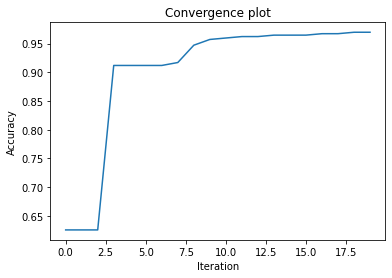

In [ ]:
results['value'].sort_values().reset_index(drop=True).plot()
plt.title('Convergence plot')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

### Optimization of CNN - TPE

we will optimize the hyperparameters of a CNN using the define-by-run model from Optuna.

In [ ]:
# For reproducible results.
# See: 
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

import os
os.environ['PYTHONHASHSEED'] = '0'

import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

In [ ]:
import itertools
from functools import partial

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam, RMSprop

In [ ]:
import optuna

#####  Data Preparation

The dataset contains information about images, each image is a hand-written digit. The aim is to have the computer predict which digit was written by the person, automatically, by "looking" at the image. 

Each image is 28 pixels in height and 28 pixels in width (28 x 28), making a total of 784 pixels. Each pixel value is an integer between 0 and 255, indicating the darkness in a gray-scale of that pixel.

The data is stored in a dataframe where each each pixel is a column (so it is flattened and not in the 28 x 28 format). 

The data set the has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

In [ ]:
# Load the data

data = pd.read_csv("../mnist.csv")

# first column is the target, the rest of the columns
# are the pixels of the image

# each row is 1 image
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['label'], axis=1), # the images
    data['label'], # the target
    test_size = 0.1,
    random_state=0)

X_train.shape, X_test.shape

((37800, 784), (4200, 784))

Text(0, 0.5, 'Number of images')

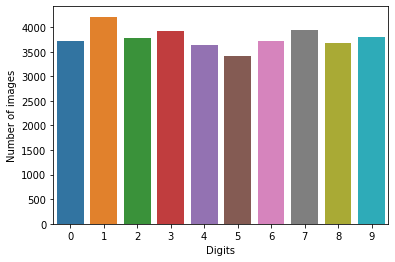

In [ ]:
# number of images for each digit

g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

There are roughly the same amount of images for each of the 10 digits.

##### Image re-scaling

We re-scale data for the CNN, between 0 and 1.

In [ ]:
# Re-scale the data

# 255 is the maximum value a pixel can take

X_train = X_train / 255
X_test = X_test / 255

##### Reshape

The images were stored in a pandas dataframe as 1-D vectors of 784 values. For a CNN with Keras, we need tensors with the following dimensions: width x height x channel. 

Thus, we reshape all data to 28 x 2 8 x 1, 3-D matrices. 

The 3rd dimension corresponds to the channel. RGB images have 3 channels. MNIST images are in gray-scale, thus they have only one channel in the 3rd dimension.

In [ ]:
# Reshape image in 3 dimensions:
# height: 28px X width: 28px X channel: 1 

X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

##### Target encoding

In [ ]:
# the target is 1 variable with the 9 different digits
# as values

y_train.unique()

array([2, 0, 7, 4, 3, 5, 9, 6, 8, 1], dtype=int64)

In [ ]:
# For Keras, we need to create 10 dummy variables,
# one for each digit

# Encode labels to one hot vectors (ex : digit 2 -> [0,0,1,0,0,0,0,0,0,0])

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

# the new target
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Let's print some example images.

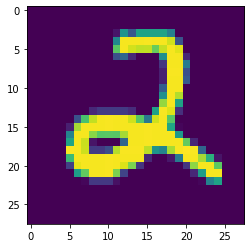

In [ ]:
# Some image examples 

g = plt.imshow(X_train[0][:,:,0])

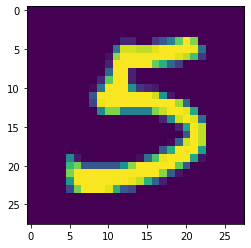

In [ ]:
# Some image examples 

g = plt.imshow(X_train[10][:,:,0])

##### Define-by-Run design

We create the CNN and add the sampling space for the hyperparameters as we go. This is the Desing-by-run concept.

In [ ]:
# we will save the model with this name
path_best_model = 'cnn_model.h5'

# starting point for the optimization
best_accuracy = 0

In [ ]:
# function to create the CNN

def objective(trial):

    # Start construction of a Keras Sequential model.
    model = Sequential()

    # Convolutional layers.

    # We add the different number of conv layers in the following loop:
    num_conv_layers = trial.suggest_int('num_conv_layers', 1, 3)

    for i in range(num_conv_layers):
        
        # NOTE: As per the below configuration, the parameters of each
        # convolutional layer will be identical.
        
        # if we want different parameters in each layer, check next
        # notebook

        model.add(Conv2D(
            filters=trial.suggest_categorical('filters', [16, 32, 64]),
            kernel_size=trial.suggest_categorical('kernel_size', [3, 5]),
            strides=trial.suggest_categorical('strides', [1, 2]),
            activation=trial.suggest_categorical(
                'activation', ['relu', 'tanh']),
            padding='same',
        ))

    # we could also optimize these parameters if we wanted:
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected Dense layer.
    model.add(Flatten())

    # Add fully-connected Dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    # We add the different number of layers in the following loop:

    num_dense_layers = trial.suggest_int('num_dense_layers', 1, 3)

    for i in range(num_dense_layers):

        # Add the dense fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes (neurons) and the activation function.
        model.add(Dense(
            units=trial.suggest_int('units', 5, 512),
            activation=trial.suggest_categorical(
                'activation', ['relu', 'tanh']),
        ))

    # Last fully-connected dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(10, activation='softmax'))

    # Use the Adam method for training the network.
    optimizer_name = trial.suggest_categorical(
        'optimizer_name', ['Adam', 'RMSprop'])

    if optimizer_name == 'Adam':
        optimizer = Adam(lr=trial.suggest_float('learning_rate',  1e-6, 1e-2))
    else:
        optimizer = RMSprop(
            lr=trial.suggest_float('learning_rate',  1e-6, 1e-2),
            momentum=trial.suggest_float('momentum',  0.1, 0.9),
        )

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # train the model
    # we use 3 epochs to be able to run the notebook in a "reasonable"
    # time. If we increase the epochs, we will have better performance
    # this could be another parameter to optimize in fact.
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=3,
        batch_size=128,
        validation_split=0.1,
    )

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        # Training CNNs is costly, so we want to avoid having to re-train
        # the network with the best found parameters. We save it instead
        # as we search for the best hyperparam space.
        model.save(path_best_model)

        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    # Remember that Scikit-optimize always minimizes the objective
    # function, so we need to negate the accuracy (because we want
    # the maximum accuracy)
    return accuracy

In [ ]:
# we need this to store the search
# we will use it in the following notebook

study_name = "cnn_study"  # unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

In [ ]:
study = optuna.create_study(
    direction='maximize',
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

study.optimize(objective, n_trials=30)

[I 2021-05-20 18:21:25,305] A new study created in RDB with name: cnn_study


Epoch 1/3
266/266 [==============================] - 35s 129ms/step - loss: 0.6645 - accuracy: 0.7852 - val_loss: 0.1099 - val_accuracy: 0.9680
Epoch 2/3
266/266 [==============================] - 44s 165ms/step - loss: 0.0933 - accuracy: 0.9726 - val_loss: 0.1159 - val_accuracy: 0.9706
Epoch 3/3
266/266 [==============================] - 45s 168ms/step - loss: 0.0532 - accuracy: 0.9835 - val_loss: 0.0680 - val_accuracy: 0.9786


[I 2021-05-20 18:23:30,697] Trial 0 finished with value: 0.9785714149475098 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 37, 'optimizer_name': 'Adam', 'learning_rate': 0.001829444754668258}. Best is trial 0 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 19s 64ms/step - loss: 0.5696 - accuracy: 0.8277 - val_loss: 0.1244 - val_accuracy: 0.9619
Epoch 2/3
266/266 [==============================] - 29s 107ms/step - loss: 0.0939 - accuracy: 0.9729 - val_loss: 0.0960 - val_accuracy: 0.9722
Epoch 3/3
266/266 [==============================] - 29s 108ms/step - loss: 0.0593 - accuracy: 0.9817 - val_loss: 0.0702 - val_accuracy: 0.9770


[I 2021-05-20 18:24:47,420] Trial 1 finished with value: 0.9769841432571411 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 1, 'units': 218, 'optimizer_name': 'Adam', 'learning_rate': 0.0017379818382761978}. Best is trial 0 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 22s 73ms/step - loss: 0.4895 - accuracy: 0.8444 - val_loss: 0.1351 - val_accuracy: 0.9569
Epoch 2/3
266/266 [==============================] - 19s 72ms/step - loss: 0.1151 - accuracy: 0.9643 - val_loss: 0.1348 - val_accuracy: 0.9622
Epoch 3/3
266/266 [==============================] - 18s 66ms/step - loss: 0.0906 - accuracy: 0.9720 - val_loss: 0.1270 - val_accuracy: 0.9648


[I 2021-05-20 18:25:46,840] Trial 2 finished with value: 0.9648148417472839 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 1, 'units': 507, 'optimizer_name': 'Adam', 'learning_rate': 0.003322291633454295}. Best is trial 0 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 52s 184ms/step - loss: 2.2703 - accuracy: 0.6681 - val_loss: 0.2135 - val_accuracy: 0.9421
Epoch 2/3
266/266 [==============================] - 50s 187ms/step - loss: 0.1185 - accuracy: 0.9670 - val_loss: 0.1391 - val_accuracy: 0.9675
Epoch 3/3
266/266 [==============================] - 48s 181ms/step - loss: 0.0806 - accuracy: 0.9784 - val_loss: 0.1239 - val_accuracy: 0.9754


[I 2021-05-20 18:28:18,233] Trial 3 finished with value: 0.9753968119621277 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 3, 'units': 316, 'optimizer_name': 'RMSprop', 'learning_rate': 0.009606442320553202, 'momentum': 0.1839557778373304}. Best is trial 0 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 49s 175ms/step - loss: 2.4964 - accuracy: 0.5550 - val_loss: 0.3006 - val_accuracy: 0.9278
Epoch 2/3
266/266 [==============================] - 46s 173ms/step - loss: 0.2159 - accuracy: 0.9451 - val_loss: 0.3561 - val_accuracy: 0.9254
Epoch 3/3
266/266 [==============================] - 42s 159ms/step - loss: 0.1631 - accuracy: 0.9585 - val_loss: 0.2338 - val_accuracy: 0.9550


[I 2021-05-20 18:30:36,895] Trial 4 finished with value: 0.9550264477729797 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 1, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 444, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00758290948203356, 'momentum': 0.27763790326823856}. Best is trial 0 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 548s 2s/step - loss: 3.5072 - accuracy: 0.1042 - val_loss: 2.4808 - val_accuracy: 0.1037
Epoch 2/3
266/266 [==============================] - 554s 2s/step - loss: 2.8719 - accuracy: 0.0990 - val_loss: 3.0300 - val_accuracy: 0.1037
Epoch 3/3
266/266 [==============================] - 627s 2s/step - loss: 2.8988 - accuracy: 0.0950 - val_loss: 2.7967 - val_accuracy: 0.1037


[I 2021-05-20 18:59:26,760] Trial 5 finished with value: 0.10370370000600815 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 3, 'strides': 1, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 455, 'optimizer_name': 'RMSprop', 'learning_rate': 0.004628385823120076, 'momentum': 0.3976856817981471}. Best is trial 0 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 33s 106ms/step - loss: 0.7561 - accuracy: 0.7479 - val_loss: 0.2741 - val_accuracy: 0.9206
Epoch 2/3
266/266 [==============================] - 25s 94ms/step - loss: 0.2273 - accuracy: 0.9368 - val_loss: 0.2374 - val_accuracy: 0.9368
Epoch 3/3
266/266 [==============================] - 13s 51ms/step - loss: 0.2195 - accuracy: 0.9406 - val_loss: 0.3410 - val_accuracy: 0.9251


[I 2021-05-20 19:00:39,744] Trial 6 finished with value: 0.9251322746276855 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 134, 'optimizer_name': 'RMSprop', 'learning_rate': 0.004260383943637079, 'momentum': 0.8557808913273667}. Best is trial 0 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 50s 179ms/step - loss: 3.0398 - accuracy: 0.1042 - val_loss: 2.3760 - val_accuracy: 0.1079
Epoch 2/3
266/266 [==============================] - 46s 171ms/step - loss: 2.5909 - accuracy: 0.1003 - val_loss: 2.5552 - val_accuracy: 0.1037
Epoch 3/3
266/266 [==============================] - 47s 176ms/step - loss: 2.5468 - accuracy: 0.1007 - val_loss: 2.8352 - val_accuracy: 0.0868


[I 2021-05-20 19:03:03,602] Trial 7 finished with value: 0.08677248656749725 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 1, 'units': 233, 'optimizer_name': 'RMSprop', 'learning_rate': 0.004457489102122301, 'momentum': 0.8159990102844568}. Best is trial 0 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 22s 69ms/step - loss: 1.5697 - accuracy: 0.4789 - val_loss: 0.4168 - val_accuracy: 0.8696
Epoch 2/3
266/266 [==============================] - 18s 69ms/step - loss: 0.3511 - accuracy: 0.8983 - val_loss: 0.2768 - val_accuracy: 0.9167
Epoch 3/3
266/266 [==============================] - 18s 68ms/step - loss: 0.2338 - accuracy: 0.9313 - val_loss: 0.2106 - val_accuracy: 0.9378


[I 2021-05-20 19:04:03,524] Trial 8 finished with value: 0.9378306865692139 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 3, 'units': 38, 'optimizer_name': 'Adam', 'learning_rate': 0.0004698200874850909}. Best is trial 0 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 15s 44ms/step - loss: 0.5480 - accuracy: 0.8222 - val_loss: 0.1262 - val_accuracy: 0.9638
Epoch 2/3
266/266 [==============================] - 11s 43ms/step - loss: 0.0970 - accuracy: 0.9695 - val_loss: 0.0979 - val_accuracy: 0.9712
Epoch 3/3
266/266 [==============================] - 10s 38ms/step - loss: 0.0662 - accuracy: 0.9788 - val_loss: 0.0957 - val_accuracy: 0.9714


[I 2021-05-20 19:04:41,119] Trial 9 finished with value: 0.9714285731315613 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 1, 'units': 433, 'optimizer_name': 'Adam', 'learning_rate': 0.006777103896145297}. Best is trial 0 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 63s 222ms/step - loss: 1.7073 - accuracy: 0.4609 - val_loss: 0.4395 - val_accuracy: 0.8733
Epoch 2/3
266/266 [==============================] - 56s 209ms/step - loss: 0.3916 - accuracy: 0.8887 - val_loss: 0.2872 - val_accuracy: 0.9156
Epoch 3/3
266/266 [==============================] - 57s 216ms/step - loss: 0.2506 - accuracy: 0.9276 - val_loss: 0.2406 - val_accuracy: 0.9280


[I 2021-05-20 19:07:37,859] Trial 10 finished with value: 0.9280423521995544 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 3, 'units': 29, 'optimizer_name': 'Adam', 'learning_rate': 0.0001223166490497982}. Best is trial 0 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 30s 103ms/step - loss: 0.6331 - accuracy: 0.8031 - val_loss: 0.1121 - val_accuracy: 0.9672
Epoch 2/3
266/266 [==============================] - 16s 61ms/step - loss: 0.0864 - accuracy: 0.9739 - val_loss: 0.0882 - val_accuracy: 0.9746
Epoch 3/3
266/266 [==============================] - 17s 66ms/step - loss: 0.0511 - accuracy: 0.9836 - val_loss: 0.0644 - val_accuracy: 0.9794


[I 2021-05-20 19:08:42,924] Trial 11 finished with value: 0.9793650507926941 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 163, 'optimizer_name': 'Adam', 'learning_rate': 0.0012097048863652128}. Best is trial 11 with value: 0.9793650507926941.


Epoch 1/3
266/266 [==============================] - 50s 177ms/step - loss: 0.5903 - accuracy: 0.8007 - val_loss: 0.1001 - val_accuracy: 0.9709
Epoch 2/3
266/266 [==============================] - 48s 181ms/step - loss: 0.0782 - accuracy: 0.9763 - val_loss: 0.0884 - val_accuracy: 0.9762
Epoch 3/3
266/266 [==============================] - 53s 199ms/step - loss: 0.0459 - accuracy: 0.9855 - val_loss: 0.0575 - val_accuracy: 0.9839


[I 2021-05-20 19:11:14,630] Trial 12 finished with value: 0.9838624596595764 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 114, 'optimizer_name': 'Adam', 'learning_rate': 0.0020539678624769604}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 31s 107ms/step - loss: 0.5337 - accuracy: 0.8276 - val_loss: 0.0857 - val_accuracy: 0.9767
Epoch 2/3
266/266 [==============================] - 28s 105ms/step - loss: 0.0688 - accuracy: 0.9784 - val_loss: 0.0782 - val_accuracy: 0.9741
Epoch 3/3
266/266 [==============================] - 25s 95ms/step - loss: 0.0415 - accuracy: 0.9860 - val_loss: 0.0597 - val_accuracy: 0.9825


[I 2021-05-20 19:12:39,961] Trial 13 finished with value: 0.9825396537780762 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 134, 'optimizer_name': 'Adam', 'learning_rate': 0.002238674984486938}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 55s 197ms/step - loss: 0.5555 - accuracy: 0.8171 - val_loss: 0.0868 - val_accuracy: 0.9735
Epoch 2/3
266/266 [==============================] - 49s 186ms/step - loss: 0.0698 - accuracy: 0.9785 - val_loss: 0.0962 - val_accuracy: 0.9714
Epoch 3/3
266/266 [==============================] - 50s 187ms/step - loss: 0.0457 - accuracy: 0.9856 - val_loss: 0.0672 - val_accuracy: 0.9783


[I 2021-05-20 19:15:15,695] Trial 14 finished with value: 0.9783068895339966 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 110, 'optimizer_name': 'Adam', 'learning_rate': 0.0027001952210941194}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 68s 242ms/step - loss: 0.9049 - accuracy: 0.6722 - val_loss: 0.1077 - val_accuracy: 0.9701
Epoch 2/3
266/266 [==============================] - 48s 179ms/step - loss: 0.1008 - accuracy: 0.9712 - val_loss: 0.1244 - val_accuracy: 0.9685
Epoch 3/3
266/266 [==============================] - 47s 175ms/step - loss: 0.0678 - accuracy: 0.9811 - val_loss: 0.0890 - val_accuracy: 0.9762


[I 2021-05-20 19:17:59,170] Trial 15 finished with value: 0.976190447807312 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 3, 'units': 299, 'optimizer_name': 'Adam', 'learning_rate': 0.006126833548088438}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 8s 26ms/step - loss: 0.6204 - accuracy: 0.8021 - val_loss: 0.1046 - val_accuracy: 0.9693
Epoch 2/3
266/266 [==============================] - 7s 27ms/step - loss: 0.0826 - accuracy: 0.9747 - val_loss: 0.0772 - val_accuracy: 0.9767
Epoch 3/3
266/266 [==============================] - 7s 26ms/step - loss: 0.0550 - accuracy: 0.9821 - val_loss: 0.0698 - val_accuracy: 0.9794


[I 2021-05-20 19:18:22,479] Trial 16 finished with value: 0.9793650507926941 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 97, 'optimizer_name': 'Adam', 'learning_rate': 0.0028115563036979524}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 387s 1s/step - loss: 0.7640 - accuracy: 0.7972 - val_loss: 0.1404 - val_accuracy: 0.9577
Epoch 2/3
266/266 [==============================] - 362s 1s/step - loss: 0.1015 - accuracy: 0.9692 - val_loss: 0.0815 - val_accuracy: 0.9757
Epoch 3/3
266/266 [==============================] - 339s 1s/step - loss: 0.0567 - accuracy: 0.9823 - val_loss: 0.0708 - val_accuracy: 0.9786


[I 2021-05-20 19:36:31,343] Trial 17 finished with value: 0.9785714149475098 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 2, 'units': 180, 'optimizer_name': 'Adam', 'learning_rate': 0.00021741034535812374}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 18s 61ms/step - loss: 0.4700 - accuracy: 0.8503 - val_loss: 0.1072 - val_accuracy: 0.9688
Epoch 2/3
266/266 [==============================] - 15s 55ms/step - loss: 0.0695 - accuracy: 0.9779 - val_loss: 0.0702 - val_accuracy: 0.9812
Epoch 3/3
266/266 [==============================] - 15s 58ms/step - loss: 0.0421 - accuracy: 0.9869 - val_loss: 0.0655 - val_accuracy: 0.9802


[I 2021-05-20 19:37:20,337] Trial 18 finished with value: 0.9801587462425232 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 1, 'units': 87, 'optimizer_name': 'Adam', 'learning_rate': 0.0034869187334927985}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 49s 173ms/step - loss: 0.7131 - accuracy: 0.7676 - val_loss: 0.1137 - val_accuracy: 0.9667
Epoch 2/3
266/266 [==============================] - 46s 172ms/step - loss: 0.0975 - accuracy: 0.9689 - val_loss: 0.0986 - val_accuracy: 0.9704
Epoch 3/3
266/266 [==============================] - 47s 175ms/step - loss: 0.0603 - accuracy: 0.9803 - val_loss: 0.0896 - val_accuracy: 0.9741


[I 2021-05-20 19:39:41,949] Trial 19 finished with value: 0.9740740656852722 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 3, 'units': 302, 'optimizer_name': 'Adam', 'learning_rate': 0.0008090843685833568}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 17s 53ms/step - loss: 0.6820 - accuracy: 0.7710 - val_loss: 0.1101 - val_accuracy: 0.9683
Epoch 2/3
266/266 [==============================] - 11s 41ms/step - loss: 0.1059 - accuracy: 0.9687 - val_loss: 0.0981 - val_accuracy: 0.9725
Epoch 3/3
266/266 [==============================] - 12s 45ms/step - loss: 0.0679 - accuracy: 0.9781 - val_loss: 0.0798 - val_accuracy: 0.9757


[I 2021-05-20 19:40:22,787] Trial 20 finished with value: 0.9756613969802856 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 181, 'optimizer_name': 'Adam', 'learning_rate': 0.0024584862687256287}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 19s 63ms/step - loss: 0.4742 - accuracy: 0.8466 - val_loss: 0.0876 - val_accuracy: 0.9770
Epoch 2/3
266/266 [==============================] - 16s 59ms/step - loss: 0.0643 - accuracy: 0.9803 - val_loss: 0.0681 - val_accuracy: 0.9807
Epoch 3/3
266/266 [==============================] - 13s 50ms/step - loss: 0.0373 - accuracy: 0.9881 - val_loss: 0.0601 - val_accuracy: 0.9815


[I 2021-05-20 19:41:11,662] Trial 21 finished with value: 0.9814814925193787 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 1, 'units': 81, 'optimizer_name': 'Adam', 'learning_rate': 0.0035657052207980705}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 18s 57ms/step - loss: 0.4434 - accuracy: 0.8547 - val_loss: 0.0863 - val_accuracy: 0.9751
Epoch 2/3
266/266 [==============================] - 15s 57ms/step - loss: 0.0596 - accuracy: 0.9821 - val_loss: 0.0629 - val_accuracy: 0.9831
Epoch 3/3
266/266 [==============================] - 15s 55ms/step - loss: 0.0360 - accuracy: 0.9875 - val_loss: 0.0711 - val_accuracy: 0.9788


[I 2021-05-20 19:41:59,653] Trial 22 finished with value: 0.9788359999656677 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 1, 'units': 69, 'optimizer_name': 'Adam', 'learning_rate': 0.005759147207410167}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 20s 72ms/step - loss: 0.4673 - accuracy: 0.8462 - val_loss: 0.0970 - val_accuracy: 0.9720
Epoch 2/3
266/266 [==============================] - 18s 67ms/step - loss: 0.0619 - accuracy: 0.9807 - val_loss: 0.0660 - val_accuracy: 0.9796
Epoch 3/3
266/266 [==============================] - 18s 69ms/step - loss: 0.0362 - accuracy: 0.9882 - val_loss: 0.0573 - val_accuracy: 0.9815


[I 2021-05-20 19:42:56,303] Trial 23 finished with value: 0.9814814925193787 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 140, 'optimizer_name': 'Adam', 'learning_rate': 0.003742762748466514}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 22s 76ms/step - loss: 0.5584 - accuracy: 0.8266 - val_loss: 0.1099 - val_accuracy: 0.9680
Epoch 2/3
266/266 [==============================] - 16s 59ms/step - loss: 0.0761 - accuracy: 0.9767 - val_loss: 0.0937 - val_accuracy: 0.9704
Epoch 3/3
266/266 [==============================] - 17s 65ms/step - loss: 0.0478 - accuracy: 0.9838 - val_loss: 0.0617 - val_accuracy: 0.9839


[I 2021-05-20 19:43:51,821] Trial 24 finished with value: 0.9838624596595764 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 143, 'optimizer_name': 'Adam', 'learning_rate': 0.0018438357670895755}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 24s 81ms/step - loss: 0.5421 - accuracy: 0.8293 - val_loss: 0.1016 - val_accuracy: 0.9698
Epoch 2/3
266/266 [==============================] - 18s 68ms/step - loss: 0.0742 - accuracy: 0.9773 - val_loss: 0.0839 - val_accuracy: 0.9738
Epoch 3/3
266/266 [==============================] - 19s 73ms/step - loss: 0.0437 - accuracy: 0.9863 - val_loss: 0.0631 - val_accuracy: 0.9820


[I 2021-05-20 19:44:53,846] Trial 25 finished with value: 0.9820106029510498 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 209, 'optimizer_name': 'Adam', 'learning_rate': 0.0015802360236340512}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 25s 87ms/step - loss: 0.4839 - accuracy: 0.8443 - val_loss: 0.0889 - val_accuracy: 0.9749
Epoch 2/3
266/266 [==============================] - 19s 73ms/step - loss: 0.0634 - accuracy: 0.9799 - val_loss: 0.0758 - val_accuracy: 0.9780
Epoch 3/3
266/266 [==============================] - 22s 82ms/step - loss: 0.0354 - accuracy: 0.9883 - val_loss: 0.0569 - val_accuracy: 0.9833


[I 2021-05-20 19:46:00,715] Trial 26 finished with value: 0.9833333492279053 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 247, 'optimizer_name': 'Adam', 'learning_rate': 0.001948405166845097}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 361s 1s/step - loss: 0.4235 - accuracy: 0.8654 - val_loss: 0.1070 - val_accuracy: 0.9677
Epoch 2/3
266/266 [==============================] - 361s 1s/step - loss: 0.0665 - accuracy: 0.9797 - val_loss: 0.0823 - val_accuracy: 0.9770
Epoch 3/3
266/266 [==============================] - 302s 1s/step - loss: 0.0344 - accuracy: 0.9893 - val_loss: 0.0808 - val_accuracy: 0.9775


[I 2021-05-20 20:03:06,337] Trial 27 finished with value: 0.9775132536888123 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 5, 'strides': 1, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 363, 'optimizer_name': 'Adam', 'learning_rate': 0.000995359918308186}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 12s 43ms/step - loss: 0.4647 - accuracy: 0.8427 - val_loss: 0.1141 - val_accuracy: 0.9677
Epoch 2/3
266/266 [==============================] - 10s 38ms/step - loss: 0.0672 - accuracy: 0.9801 - val_loss: 0.1051 - val_accuracy: 0.9725
Epoch 3/3
266/266 [==============================] - 11s 42ms/step - loss: 0.0481 - accuracy: 0.9850 - val_loss: 0.0698 - val_accuracy: 0.9794


[I 2021-05-20 20:03:40,031] Trial 28 finished with value: 0.9793650507926941 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 3, 'units': 261, 'optimizer_name': 'Adam', 'learning_rate': 0.0053649847727488004}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 32s 117ms/step - loss: 1.7501 - accuracy: 0.3009 - val_loss: 1.1696 - val_accuracy: 0.5071
Epoch 2/3
266/266 [==============================] - 30s 113ms/step - loss: 1.0785 - accuracy: 0.5502 - val_loss: 0.4733 - val_accuracy: 0.8606
Epoch 3/3
266/266 [==============================] - 30s 115ms/step - loss: 0.3229 - accuracy: 0.8997 - val_loss: 0.1988 - val_accuracy: 0.9614


[I 2021-05-20 20:05:12,528] Trial 29 finished with value: 0.9613756537437439 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 6, 'optimizer_name': 'Adam', 'learning_rate': 0.0019550329335437837}. Best is trial 12 with value: 0.9838624596595764.


##### Analyze results

In [ ]:
study.best_params

{'activation': 'relu',
 'filters': 64,
 'kernel_size': 5,
 'learning_rate': 0.0020539678624769604,
 'num_conv_layers': 3,
 'num_dense_layers': 2,
 'optimizer_name': 'Adam',
 'strides': 2,
 'units': 114}

In [ ]:
study.best_value

0.9838624596595764

Text(0, 0.5, 'Accuracy')

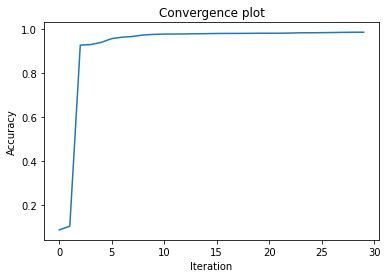

In [ ]:
results = study.trials_dataframe()

results['value'].sort_values().reset_index(drop=True).plot()
plt.title('Convergence plot')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

##### Evaluate the model

In [ ]:
# load best model

model = load_model(path_best_model)

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 7, 7, 64)          102464    
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 4, 4, 64)          102464    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 114)               29298     
_________________________________________________________________
dense_36 (Dense)             (None, 114)             

In [ ]:
# make predictions in test set

result = model.evaluate(x=X_test,
                        y=y_test)

132/132 [==============================] - 1s 7ms/step - loss: 0.0597 - accuracy: 0.9821


In [ ]:
# print evaluation metrics

for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.05974521115422249
accuracy 0.9821428656578064


##### Confusion matrix

In [ ]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1)

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) 

cm

array([[416,   0,   0,   0,   1,   0,   2,   0,   3,   0],
       [  0, 466,   3,   0,   0,   0,   1,   2,   1,   0],
       [  2,   0, 405,   1,   0,   0,   0,   0,   1,   0],
       [  0,   0,   1, 419,   0,   1,   1,   3,   0,   1],
       [  1,   3,   0,   0, 419,   0,   3,   0,   0,   3],
       [  0,   0,   0,   1,   0, 376,   2,   0,   3,   0],
       [  0,   0,   0,   0,   2,   0, 409,   0,   1,   0],
       [  0,   2,   6,   1,   0,   1,   0, 457,   0,   2],
       [  0,   1,   1,   0,   0,   0,   1,   1, 379,   1],
       [  2,   2,   0,   4,   5,   0,   0,   1,   1, 379]], dtype=int64)

Text(0.5, 13.421126458070283, 'Predicted label')

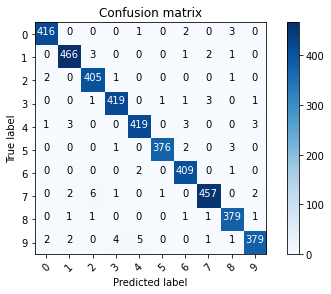

In [ ]:
# let's make it more colourful
classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Here we can see that our CNN performs very well on all digits.

### Optimization of CNN - TPE

we will optimize the hyperparameters of a CNN using the define-by-run model from Optuna.

In [ ]:
# For reproducible results.
# See: 
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

import os
os.environ['PYTHONHASHSEED'] = '0'

import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

In [ ]:
import itertools
from functools import partial

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam, RMSprop

In [ ]:
import optuna

#####  Data Preparation

The dataset contains information about images, each image is a hand-written digit. The aim is to have the computer predict which digit was written by the person, automatically, by "looking" at the image. 

Each image is 28 pixels in height and 28 pixels in width (28 x 28), making a total of 784 pixels. Each pixel value is an integer between 0 and 255, indicating the darkness in a gray-scale of that pixel.

The data is stored in a dataframe where each each pixel is a column (so it is flattened and not in the 28 x 28 format). 

The data set the has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

In [ ]:
# Load the data

data = pd.read_csv("../mnist.csv")

# first column is the target, the rest of the columns
# are the pixels of the image

# each row is 1 image
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['label'], axis=1), # the images
    data['label'], # the target
    test_size = 0.1,
    random_state=0)

X_train.shape, X_test.shape

((37800, 784), (4200, 784))

Text(0, 0.5, 'Number of images')

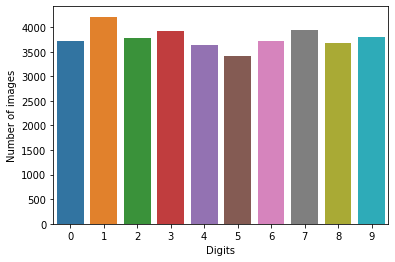

In [ ]:
# number of images for each digit

g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

There are roughly the same amount of images for each of the 10 digits.

##### Image re-scaling

We re-scale data for the CNN, between 0 and 1.

In [ ]:
# Re-scale the data

# 255 is the maximum value a pixel can take

X_train = X_train / 255
X_test = X_test / 255

##### Reshape

The images were stored in a pandas dataframe as 1-D vectors of 784 values. For a CNN with Keras, we need tensors with the following dimensions: width x height x channel. 

Thus, we reshape all data to 28 x 2 8 x 1, 3-D matrices. 

The 3rd dimension corresponds to the channel. RGB images have 3 channels. MNIST images are in gray-scale, thus they have only one channel in the 3rd dimension.

In [ ]:
# Reshape image in 3 dimensions:
# height: 28px X width: 28px X channel: 1 

X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

##### Target encoding

In [ ]:
# the target is 1 variable with the 9 different digits
# as values

y_train.unique()

array([2, 0, 7, 4, 3, 5, 9, 6, 8, 1], dtype=int64)

In [ ]:
# For Keras, we need to create 10 dummy variables,
# one for each digit

# Encode labels to one hot vectors (ex : digit 2 -> [0,0,1,0,0,0,0,0,0,0])

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

# the new target
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Let's print some example images.

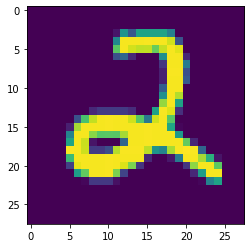

In [ ]:
# Some image examples 

g = plt.imshow(X_train[0][:,:,0])

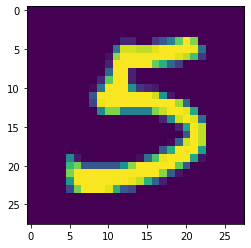

In [ ]:
# Some image examples 

g = plt.imshow(X_train[10][:,:,0])

##### Define-by-Run design

We create the CNN and add the sampling space for the hyperparameters as we go. This is the Desing-by-run concept.

In [ ]:
# we will save the model with this name
path_best_model = 'cnn_model_2.h5'

# starting point for the optimization
best_accuracy = 0

In [ ]:
# function to create the CNN

def objective(trial):

    # Start construction of a Keras Sequential model.
    model = Sequential()

    # Convolutional layers.

    # We add the different number of conv layers in the following loop:
    num_conv_layers = trial.suggest_int('num_conv_layers', 1, 3)

    for i in range(num_conv_layers):
        
        # Note, with this configuration, we sample different filters, kernels
        # stride etc, for each convolutional layer that we add

        model.add(Conv2D(
            filters=trial.suggest_categorical('filters_{}'.format(i), [16, 32, 64]),
            kernel_size=trial.suggest_categorical('kernel_size{}'.format(i), [3, 5]),
            strides=trial.suggest_categorical('strides{}'.format(i), [1, 2]),
            activation=trial.suggest_categorical(
                'activation{}'.format(i), ['relu', 'tanh']),
            padding='same',
        ))

    # we could also optimize these parameters if we wanted:
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected Dense layer.
    model.add(Flatten())

    # Add fully-connected Dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    # We add the different number of layers in the following loop:

    num_dense_layers = trial.suggest_int('num_dense_layers', 1, 3)

    for i in range(num_dense_layers):

        # Add the dense fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes (neurons) and the activation function.
        model.add(Dense(
            units=trial.suggest_int('units{}'.format(i), 5, 512),
            activation=trial.suggest_categorical(
                'activation{}'.format(i), ['relu', 'tanh']),
        ))

    # Last fully-connected dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(10, activation='softmax'))

    # Use the Adam method for training the network.
    optimizer_name = trial.suggest_categorical(
        'optimizer_name', ['Adam', 'RMSprop'])

    if optimizer_name == 'Adam':
        optimizer = Adam(lr=trial.suggest_float('learning_rate',  1e-6, 1e-2))
    else:
        optimizer = RMSprop(
            lr=trial.suggest_float('learning_rate',  1e-6, 1e-2),
            momentum=trial.suggest_float('momentum',  0.1, 0.9),
        )

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # train the model
    # we use 3 epochs to be able to run the notebook in a "reasonable"
    # time. If we increase the epochs, we will have better performance
    # this could be another parameter to optimize in fact.
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=3,
        batch_size=128,
        validation_split=0.1,
    )

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        # Training CNNs is costly, so we want to avoid having to re-train
        # the network with the best found parameters. We save it instead
        # as we search for the best hyperparam space.
        model.save(path_best_model)

        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    # Remember that Scikit-optimize always minimizes the objective
    # function, so we need to negate the accuracy (because we want
    # the maximum accuracy)
    return accuracy

In [ ]:
# we need this to store the search
# we will use it in the following notebook

study_name = "cnn_study_2"  # unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

In [ ]:
study = optuna.create_study(
    direction='maximize',
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

study.optimize(objective, n_trials=30)

[I 2021-05-20 18:21:58,048] A new study created in RDB with name: cnn_study_2


Epoch 1/3
266/266 [==============================] - 39s 144ms/step - loss: 0.5335 - accuracy: 0.8488 - val_loss: 0.1405 - val_accuracy: 0.9590
Epoch 2/3
266/266 [==============================] - 36s 136ms/step - loss: 0.0888 - accuracy: 0.9710 - val_loss: 0.1039 - val_accuracy: 0.9720
Epoch 3/3
266/266 [==============================] - 30s 114ms/step - loss: 0.0468 - accuracy: 0.9851 - val_loss: 0.1000 - val_accuracy: 0.9733


[I 2021-05-20 18:23:45,091] Trial 0 finished with value: 0.9732804298400879 and parameters: {'num_conv_layers': 1, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'tanh', 'num_dense_layers': 1, 'units0': 389, 'optimizer_name': 'Adam', 'learning_rate': 0.005141375818387415}. Best is trial 0 with value: 0.9732804298400879.


Epoch 1/3
266/266 [==============================] - 132s 487ms/step - loss: 1.4591 - accuracy: 0.6059 - val_loss: 0.2752 - val_accuracy: 0.9164
Epoch 2/3
266/266 [==============================] - 138s 520ms/step - loss: 0.2207 - accuracy: 0.9318 - val_loss: 0.2164 - val_accuracy: 0.9357
Epoch 3/3
266/266 [==============================] - 133s 499ms/step - loss: 0.1591 - accuracy: 0.9494 - val_loss: 0.2193 - val_accuracy: 0.9344


[I 2021-05-20 18:30:28,771] Trial 1 finished with value: 0.9343915581703186 and parameters: {'num_conv_layers': 3, 'filters_0': 16, 'kernel_size0': 3, 'strides0': 1, 'activation0': 'tanh', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 2, 'activation1': 'tanh', 'filters_2': 64, 'kernel_size2': 5, 'strides2': 1, 'activation2': 'tanh', 'num_dense_layers': 2, 'units0': 353, 'units1': 297, 'optimizer_name': 'Adam', 'learning_rate': 0.006688787074386754}. Best is trial 0 with value: 0.9732804298400879.


Epoch 1/3
266/266 [==============================] - 330s 1s/step - loss: 15.9149 - accuracy: 0.1087 - val_loss: 2.3023 - val_accuracy: 0.1146
Epoch 2/3
266/266 [==============================] - 326s 1s/step - loss: 2.3031 - accuracy: 0.1079 - val_loss: 2.3034 - val_accuracy: 0.1146
Epoch 3/3
266/266 [==============================] - 329s 1s/step - loss: 2.3028 - accuracy: 0.1108 - val_loss: 2.3046 - val_accuracy: 0.0960


[I 2021-05-20 18:46:56,234] Trial 2 finished with value: 0.09603174775838852 and parameters: {'num_conv_layers': 3, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 16, 'kernel_size1': 5, 'strides1': 1, 'activation1': 'relu', 'filters_2': 64, 'kernel_size2': 3, 'strides2': 1, 'activation2': 'tanh', 'num_dense_layers': 1, 'units0': 334, 'optimizer_name': 'RMSprop', 'learning_rate': 0.007158060825068953, 'momentum': 0.7288210488996536}. Best is trial 0 with value: 0.9732804298400879.


Epoch 1/3
266/266 [==============================] - 278s 1s/step - loss: 3.8213 - accuracy: 0.1001 - val_loss: 3.1188 - val_accuracy: 0.1079
Epoch 2/3
266/266 [==============================] - 278s 1s/step - loss: 2.6303 - accuracy: 0.1038 - val_loss: 3.9200 - val_accuracy: 0.1037
Epoch 3/3
266/266 [==============================] - 259s 976ms/step - loss: 2.8060 - accuracy: 0.1006 - val_loss: 2.9851 - val_accuracy: 0.1037


[I 2021-05-20 19:00:32,491] Trial 3 finished with value: 0.10370370000600815 and parameters: {'num_conv_layers': 2, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'tanh', 'filters_1': 32, 'kernel_size1': 5, 'strides1': 1, 'activation1': 'tanh', 'num_dense_layers': 2, 'units0': 24, 'units1': 441, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00965484036942336, 'momentum': 0.46253966715483774}. Best is trial 0 with value: 0.9732804298400879.


Epoch 1/3
266/266 [==============================] - 160s 595ms/step - loss: 0.9944 - accuracy: 0.7624 - val_loss: 0.1286 - val_accuracy: 0.9614
Epoch 2/3
266/266 [==============================] - 140s 528ms/step - loss: 0.0980 - accuracy: 0.9722 - val_loss: 0.1152 - val_accuracy: 0.9693
Epoch 3/3
266/266 [==============================] - 157s 589ms/step - loss: 0.0650 - accuracy: 0.9817 - val_loss: 0.0926 - val_accuracy: 0.9765


[I 2021-05-20 19:08:10,412] Trial 4 finished with value: 0.97645503282547 and parameters: {'num_conv_layers': 2, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 16, 'kernel_size1': 5, 'strides1': 1, 'activation1': 'relu', 'num_dense_layers': 1, 'units0': 255, 'optimizer_name': 'RMSprop', 'learning_rate': 0.008853217919545443, 'momentum': 0.17963032837491807}. Best is trial 4 with value: 0.97645503282547.


Epoch 1/3
266/266 [==============================] - 14s 46ms/step - loss: 2.0599 - accuracy: 0.5772 - val_loss: 0.1980 - val_accuracy: 0.9402
Epoch 2/3
266/266 [==============================] - 11s 43ms/step - loss: 0.1562 - accuracy: 0.9547 - val_loss: 0.1951 - val_accuracy: 0.9566
Epoch 3/3
266/266 [==============================] - 10s 36ms/step - loss: 0.1074 - accuracy: 0.9706 - val_loss: 0.1643 - val_accuracy: 0.9653


[I 2021-05-20 19:08:46,372] Trial 5 finished with value: 0.9653438925743103 and parameters: {'num_conv_layers': 1, 'filters_0': 32, 'kernel_size0': 3, 'strides0': 2, 'activation0': 'tanh', 'num_dense_layers': 2, 'units0': 286, 'units1': 192, 'activation1': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.008840779453710527, 'momentum': 0.14435937843393642}. Best is trial 4 with value: 0.97645503282547.


Epoch 1/3
266/266 [==============================] - 43s 151ms/step - loss: 0.4753 - accuracy: 0.8437 - val_loss: 0.1221 - val_accuracy: 0.9646
Epoch 2/3
266/266 [==============================] - 40s 149ms/step - loss: 0.0984 - accuracy: 0.9691 - val_loss: 0.1237 - val_accuracy: 0.9616
Epoch 3/3
266/266 [==============================] - 39s 147ms/step - loss: 0.0881 - accuracy: 0.9719 - val_loss: 0.1636 - val_accuracy: 0.9500


[I 2021-05-20 19:10:50,072] Trial 6 finished with value: 0.949999988079071 and parameters: {'num_conv_layers': 3, 'filters_0': 32, 'kernel_size0': 3, 'strides0': 2, 'activation0': 'tanh', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 2, 'activation1': 'relu', 'filters_2': 64, 'kernel_size2': 3, 'strides2': 2, 'activation2': 'tanh', 'num_dense_layers': 1, 'units0': 152, 'optimizer_name': 'Adam', 'learning_rate': 0.009013413254775211}. Best is trial 4 with value: 0.97645503282547.


Epoch 1/3
266/266 [==============================] - 107s 394ms/step - loss: 2.4334 - accuracy: 0.1073 - val_loss: 2.3023 - val_accuracy: 0.1146
Epoch 2/3
266/266 [==============================] - 117s 440ms/step - loss: 2.3030 - accuracy: 0.1081 - val_loss: 2.3032 - val_accuracy: 0.1146
Epoch 3/3
266/266 [==============================] - 118s 444ms/step - loss: 2.3026 - accuracy: 0.1104 - val_loss: 2.3042 - val_accuracy: 0.0960


[I 2021-05-20 19:16:33,546] Trial 7 finished with value: 0.09603174775838852 and parameters: {'num_conv_layers': 3, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 32, 'kernel_size1': 5, 'strides1': 2, 'activation1': 'tanh', 'filters_2': 16, 'kernel_size2': 3, 'strides2': 1, 'activation2': 'relu', 'num_dense_layers': 1, 'units0': 239, 'optimizer_name': 'RMSprop', 'learning_rate': 0.006119554297468513, 'momentum': 0.7533193443015165}. Best is trial 4 with value: 0.97645503282547.


Epoch 1/3
266/266 [==============================] - 46s 164ms/step - loss: 0.9413 - accuracy: 0.7100 - val_loss: 0.2274 - val_accuracy: 0.9339
Epoch 2/3
266/266 [==============================] - 40s 152ms/step - loss: 0.1918 - accuracy: 0.9406 - val_loss: 0.1696 - val_accuracy: 0.9519
Epoch 3/3
266/266 [==============================] - 45s 171ms/step - loss: 0.1095 - accuracy: 0.9638 - val_loss: 0.1211 - val_accuracy: 0.9635


[I 2021-05-20 19:18:46,460] Trial 8 finished with value: 0.9634920358657837 and parameters: {'num_conv_layers': 2, 'filters_0': 32, 'kernel_size0': 3, 'strides0': 1, 'activation0': 'relu', 'filters_1': 16, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'num_dense_layers': 3, 'units0': 242, 'units1': 236, 'units2': 319, 'activation2': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.0002461643466692788, 'momentum': 0.18819892384189763}. Best is trial 4 with value: 0.97645503282547.


Epoch 1/3
266/266 [==============================] - 194s 716ms/step - loss: 0.4790 - accuracy: 0.8544 - val_loss: 0.1363 - val_accuracy: 0.9619
Epoch 2/3
266/266 [==============================] - 181s 679ms/step - loss: 0.1077 - accuracy: 0.9683 - val_loss: 0.1090 - val_accuracy: 0.9725
Epoch 3/3
266/266 [==============================] - 184s 692ms/step - loss: 0.0924 - accuracy: 0.9703 - val_loss: 0.1306 - val_accuracy: 0.9606


[I 2021-05-20 19:28:06,938] Trial 9 finished with value: 0.9605820178985596 and parameters: {'num_conv_layers': 2, 'filters_0': 16, 'kernel_size0': 3, 'strides0': 1, 'activation0': 'tanh', 'filters_1': 32, 'kernel_size1': 5, 'strides1': 1, 'activation1': 'tanh', 'num_dense_layers': 1, 'units0': 72, 'optimizer_name': 'Adam', 'learning_rate': 0.0059181104466350535}. Best is trial 4 with value: 0.97645503282547.


Epoch 1/3
266/266 [==============================] - 36s 123ms/step - loss: 0.8766 - accuracy: 0.6965 - val_loss: 0.0956 - val_accuracy: 0.9714
Epoch 2/3
266/266 [==============================] - 32s 121ms/step - loss: 0.0825 - accuracy: 0.9755 - val_loss: 0.0715 - val_accuracy: 0.9796
Epoch 3/3
266/266 [==============================] - 33s 125ms/step - loss: 0.0478 - accuracy: 0.9856 - val_loss: 0.0789 - val_accuracy: 0.9799


[I 2021-05-20 19:29:49,611] Trial 10 finished with value: 0.9798941612243652 and parameters: {'num_conv_layers': 1, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'num_dense_layers': 3, 'units0': 473, 'units1': 12, 'activation1': 'relu', 'units2': 11, 'activation2': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.00266296121411845, 'momentum': 0.46432988966267597}. Best is trial 10 with value: 0.9798941612243652.


Epoch 1/3
266/266 [==============================] - 39s 135ms/step - loss: 0.8934 - accuracy: 0.6795 - val_loss: 0.1433 - val_accuracy: 0.9616
Epoch 2/3
266/266 [==============================] - 32s 119ms/step - loss: 0.0858 - accuracy: 0.9747 - val_loss: 0.0744 - val_accuracy: 0.9802
Epoch 3/3
266/266 [==============================] - 38s 142ms/step - loss: 0.0506 - accuracy: 0.9844 - val_loss: 0.0712 - val_accuracy: 0.9812


[I 2021-05-20 19:31:40,207] Trial 11 finished with value: 0.9812169075012207 and parameters: {'num_conv_layers': 1, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'num_dense_layers': 3, 'units0': 495, 'units1': 11, 'activation1': 'relu', 'units2': 20, 'activation2': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.0026108673783509046, 'momentum': 0.4363176998524363}. Best is trial 11 with value: 0.9812169075012207.


Epoch 1/3
266/266 [==============================] - 40s 139ms/step - loss: 1.0620 - accuracy: 0.6063 - val_loss: 0.0927 - val_accuracy: 0.9712
Epoch 2/3
266/266 [==============================] - 34s 130ms/step - loss: 0.0787 - accuracy: 0.9756 - val_loss: 0.0777 - val_accuracy: 0.9788
Epoch 3/3
266/266 [==============================] - 36s 135ms/step - loss: 0.0461 - accuracy: 0.9858 - val_loss: 0.0605 - val_accuracy: 0.9833


[I 2021-05-20 19:33:35,474] Trial 12 finished with value: 0.9833333492279053 and parameters: {'num_conv_layers': 1, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'num_dense_layers': 3, 'units0': 492, 'units1': 12, 'activation1': 'relu', 'units2': 17, 'activation2': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.0022406478015239675, 'momentum': 0.44436701977005505}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 39s 136ms/step - loss: 2.3024 - accuracy: 0.1112 - val_loss: 2.3014 - val_accuracy: 0.1146
Epoch 2/3
266/266 [==============================] - 34s 128ms/step - loss: 2.3015 - accuracy: 0.1078 - val_loss: 2.3008 - val_accuracy: 0.1146
Epoch 3/3
266/266 [==============================] - 33s 126ms/step - loss: 2.3011 - accuracy: 0.1133 - val_loss: 2.3013 - val_accuracy: 0.1146


[I 2021-05-20 19:35:23,960] Trial 13 finished with value: 0.11455026268959045 and parameters: {'num_conv_layers': 1, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'num_dense_layers': 3, 'units0': 490, 'units1': 30, 'activation1': 'relu', 'units2': 6, 'activation2': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.002530026702391447, 'momentum': 0.35069250188205026}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 46s 153ms/step - loss: 0.5659 - accuracy: 0.8023 - val_loss: 0.0936 - val_accuracy: 0.9712
Epoch 2/3
266/266 [==============================] - 23s 87ms/step - loss: 0.0799 - accuracy: 0.9756 - val_loss: 0.0898 - val_accuracy: 0.9807
Epoch 3/3
266/266 [==============================] - 16s 59ms/step - loss: 0.0534 - accuracy: 0.9845 - val_loss: 0.0862 - val_accuracy: 0.9802


[I 2021-05-20 19:36:49,954] Trial 14 finished with value: 0.9801587462425232 and parameters: {'num_conv_layers': 1, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'num_dense_layers': 3, 'units0': 511, 'units1': 89, 'activation1': 'relu', 'units2': 100, 'activation2': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.0025632692193490996, 'momentum': 0.6203955760637716}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 18s 61ms/step - loss: 0.8192 - accuracy: 0.7555 - val_loss: 0.1437 - val_accuracy: 0.9577
Epoch 2/3
266/266 [==============================] - 13s 50ms/step - loss: 0.1219 - accuracy: 0.9634 - val_loss: 0.0904 - val_accuracy: 0.9754
Epoch 3/3
266/266 [==============================] - 19s 71ms/step - loss: 0.0720 - accuracy: 0.9779 - val_loss: 0.0756 - val_accuracy: 0.9783


[I 2021-05-20 19:37:41,140] Trial 15 finished with value: 0.9783068895339966 and parameters: {'num_conv_layers': 1, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'num_dense_layers': 3, 'units0': 426, 'units1': 125, 'activation1': 'relu', 'units2': 162, 'activation2': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.00033920633903364956, 'momentum': 0.36545400651270277}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 24s 81ms/step - loss: 2.3198 - accuracy: 0.1095 - val_loss: 2.3020 - val_accuracy: 0.1146
Epoch 2/3
266/266 [==============================] - 21s 78ms/step - loss: 2.3019 - accuracy: 0.1085 - val_loss: 2.3013 - val_accuracy: 0.1146
Epoch 3/3
266/266 [==============================] - 20s 77ms/step - loss: 2.3016 - accuracy: 0.1130 - val_loss: 2.3021 - val_accuracy: 0.1146


[I 2021-05-20 19:38:47,745] Trial 16 finished with value: 0.11455026268959045 and parameters: {'num_conv_layers': 1, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'num_dense_layers': 3, 'units0': 512, 'units1': 5, 'activation1': 'relu', 'units2': 453, 'activation2': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.0037385944284192623, 'momentum': 0.5925387072087202}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 30s 103ms/step - loss: 0.6419 - accuracy: 0.7787 - val_loss: 0.1273 - val_accuracy: 0.9601
Epoch 2/3
266/266 [==============================] - 24s 91ms/step - loss: 0.0733 - accuracy: 0.9773 - val_loss: 0.0718 - val_accuracy: 0.9794
Epoch 3/3
266/266 [==============================] - 17s 65ms/step - loss: 0.0484 - accuracy: 0.9834 - val_loss: 0.0696 - val_accuracy: 0.9833


[I 2021-05-20 19:40:00,164] Trial 17 finished with value: 0.9833333492279053 and parameters: {'num_conv_layers': 2, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 438, 'units1': 361, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0015754677956798648, 'momentum': 0.32212559844402117}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 22s 75ms/step - loss: 0.6547 - accuracy: 0.7769 - val_loss: 0.1013 - val_accuracy: 0.9659
Epoch 2/3
266/266 [==============================] - 17s 64ms/step - loss: 0.0836 - accuracy: 0.9745 - val_loss: 0.0715 - val_accuracy: 0.9799
Epoch 3/3
266/266 [==============================] - 18s 68ms/step - loss: 0.0503 - accuracy: 0.9842 - val_loss: 0.0657 - val_accuracy: 0.9825


[I 2021-05-20 19:40:58,128] Trial 18 finished with value: 0.9825396537780762 and parameters: {'num_conv_layers': 2, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 429, 'units1': 371, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0010183930139164455, 'momentum': 0.3366026137766247}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 21s 72ms/step - loss: 0.7040 - accuracy: 0.7696 - val_loss: 0.1044 - val_accuracy: 0.9683
Epoch 2/3
266/266 [==============================] - 20s 75ms/step - loss: 0.0776 - accuracy: 0.9762 - val_loss: 0.0792 - val_accuracy: 0.9765
Epoch 3/3
266/266 [==============================] - 20s 75ms/step - loss: 0.0465 - accuracy: 0.9845 - val_loss: 0.0896 - val_accuracy: 0.9754


[I 2021-05-20 19:41:59,982] Trial 19 finished with value: 0.9753968119621277 and parameters: {'num_conv_layers': 2, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 454, 'units1': 502, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0013990189028376516, 'momentum': 0.2456932707628172}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 29s 104ms/step - loss: 0.5612 - accuracy: 0.8096 - val_loss: 0.1072 - val_accuracy: 0.9698
Epoch 2/3
266/266 [==============================] - 27s 103ms/step - loss: 0.0864 - accuracy: 0.9730 - val_loss: 0.0785 - val_accuracy: 0.9775
Epoch 3/3
266/266 [==============================] - 26s 97ms/step - loss: 0.0529 - accuracy: 0.9832 - val_loss: 0.0710 - val_accuracy: 0.9802


[I 2021-05-20 19:43:22,987] Trial 20 finished with value: 0.9801587462425232 and parameters: {'num_conv_layers': 2, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 365, 'units1': 347, 'optimizer_name': 'Adam', 'learning_rate': 0.004043506574357688}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 22s 74ms/step - loss: 0.6677 - accuracy: 0.7735 - val_loss: 0.0939 - val_accuracy: 0.9704
Epoch 2/3
266/266 [==============================] - 18s 67ms/step - loss: 0.0816 - accuracy: 0.9734 - val_loss: 0.0787 - val_accuracy: 0.9762
Epoch 3/3
266/266 [==============================] - 18s 68ms/step - loss: 0.0503 - accuracy: 0.9833 - val_loss: 0.0806 - val_accuracy: 0.9799


[I 2021-05-20 19:44:21,787] Trial 21 finished with value: 0.9798941612243652 and parameters: {'num_conv_layers': 2, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 421, 'units1': 380, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0012142160592243192, 'momentum': 0.30285960276296225}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 22s 75ms/step - loss: 0.5726 - accuracy: 0.8092 - val_loss: 0.1154 - val_accuracy: 0.9659
Epoch 2/3
266/266 [==============================] - 17s 66ms/step - loss: 0.0775 - accuracy: 0.9773 - val_loss: 0.0874 - val_accuracy: 0.9746
Epoch 3/3
266/266 [==============================] - 20s 75ms/step - loss: 0.0537 - accuracy: 0.9823 - val_loss: 0.0782 - val_accuracy: 0.9786


[I 2021-05-20 19:45:22,243] Trial 22 finished with value: 0.9785714149475098 and parameters: {'num_conv_layers': 2, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 425, 'units1': 407, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0012777581333840336, 'momentum': 0.5718739184449542}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 21s 71ms/step - loss: 1.9920 - accuracy: 0.4302 - val_loss: 0.7837 - val_accuracy: 0.7690
Epoch 2/3
266/266 [==============================] - 18s 66ms/step - loss: 0.6261 - accuracy: 0.8274 - val_loss: 0.4041 - val_accuracy: 0.8828
Epoch 3/3
266/266 [==============================] - 34s 127ms/step - loss: 0.3481 - accuracy: 0.8993 - val_loss: 0.2832 - val_accuracy: 0.9161


[I 2021-05-20 19:46:35,670] Trial 23 finished with value: 0.9161375761032104 and parameters: {'num_conv_layers': 2, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 310, 'units1': 316, 'optimizer_name': 'RMSprop', 'learning_rate': 5.246165136033043e-05, 'momentum': 0.28644870235279585}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 50s 174ms/step - loss: 0.6108 - accuracy: 0.7899 - val_loss: 0.0988 - val_accuracy: 0.9709
Epoch 2/3
266/266 [==============================] - 44s 165ms/step - loss: 0.0781 - accuracy: 0.9772 - val_loss: 0.0993 - val_accuracy: 0.9730
Epoch 3/3
266/266 [==============================] - 44s 167ms/step - loss: 0.0541 - accuracy: 0.9824 - val_loss: 0.0886 - val_accuracy: 0.9772


[I 2021-05-20 19:48:55,305] Trial 24 finished with value: 0.9772486686706543 and parameters: {'num_conv_layers': 2, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 392, 'units1': 454, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0017651664912190653, 'momentum': 0.34484967768252434}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 40s 132ms/step - loss: 0.7095 - accuracy: 0.7715 - val_loss: 0.1011 - val_accuracy: 0.9690
Epoch 2/3
266/266 [==============================] - 34s 127ms/step - loss: 0.0959 - accuracy: 0.9706 - val_loss: 0.1296 - val_accuracy: 0.9659
Epoch 3/3
266/266 [==============================] - 32s 121ms/step - loss: 0.0671 - accuracy: 0.9793 - val_loss: 0.1146 - val_accuracy: 0.9722


[I 2021-05-20 19:50:42,459] Trial 25 finished with value: 0.9722222089767456 and parameters: {'num_conv_layers': 2, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 451, 'units1': 273, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0037659996196933387, 'momentum': 0.3932583381933051}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 65s 229ms/step - loss: 0.8563 - accuracy: 0.7081 - val_loss: 0.1224 - val_accuracy: 0.9640
Epoch 2/3
266/266 [==============================] - 51s 193ms/step - loss: 0.1082 - accuracy: 0.9681 - val_loss: 0.0980 - val_accuracy: 0.9754
Epoch 3/3
266/266 [==============================] - 58s 218ms/step - loss: 0.0658 - accuracy: 0.9799 - val_loss: 0.0852 - val_accuracy: 0.9754


[I 2021-05-20 19:53:38,312] Trial 26 finished with value: 0.9753968119621277 and parameters: {'num_conv_layers': 3, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'filters_2': 32, 'kernel_size2': 5, 'strides2': 2, 'activation2': 'relu', 'num_dense_layers': 3, 'units0': 510, 'units1': 360, 'units2': 283, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0007843290128324143, 'momentum': 0.2470896291688005}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 43s 145ms/step - loss: 0.5644 - accuracy: 0.8088 - val_loss: 0.1108 - val_accuracy: 0.9667
Epoch 2/3
266/266 [==============================] - 35s 131ms/step - loss: 0.0833 - accuracy: 0.9750 - val_loss: 0.0914 - val_accuracy: 0.9751
Epoch 3/3
266/266 [==============================] - 34s 129ms/step - loss: 0.0578 - accuracy: 0.9828 - val_loss: 0.1003 - val_accuracy: 0.9775


[I 2021-05-20 19:55:31,687] Trial 27 finished with value: 0.9775132536888123 and parameters: {'num_conv_layers': 2, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 188, 'units1': 473, 'optimizer_name': 'RMSprop', 'learning_rate': 0.001971584235483052, 'momentum': 0.5485776970569619}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 45s 157ms/step - loss: 0.5682 - accuracy: 0.8105 - val_loss: 0.1003 - val_accuracy: 0.9690
Epoch 2/3
266/266 [==============================] - 44s 165ms/step - loss: 0.0766 - accuracy: 0.9782 - val_loss: 0.0834 - val_accuracy: 0.9772
Epoch 3/3
266/266 [==============================] - 40s 149ms/step - loss: 0.0615 - accuracy: 0.9828 - val_loss: 0.0821 - val_accuracy: 0.9788


[I 2021-05-20 19:57:41,781] Trial 28 finished with value: 0.9788359999656677 and parameters: {'num_conv_layers': 2, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'tanh', 'num_dense_layers': 2, 'units0': 391, 'units1': 213, 'optimizer_name': 'RMSprop', 'learning_rate': 0.003471293944456694, 'momentum': 0.4149447395144391}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 22s 72ms/step - loss: 0.4415 - accuracy: 0.8581 - val_loss: 0.0868 - val_accuracy: 0.9754
Epoch 2/3
266/266 [==============================] - 23s 87ms/step - loss: 0.0617 - accuracy: 0.9808 - val_loss: 0.0767 - val_accuracy: 0.9783
Epoch 3/3
266/266 [==============================] - 24s 90ms/step - loss: 0.0359 - accuracy: 0.9882 - val_loss: 0.0647 - val_accuracy: 0.9807


[I 2021-05-20 19:58:52,370] Trial 29 finished with value: 0.9806878566741943 and parameters: {'num_conv_layers': 1, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'num_dense_layers': 1, 'units0': 456, 'optimizer_name': 'Adam', 'learning_rate': 0.005028155276375773}. Best is trial 12 with value: 0.9833333492279053.


#### Analyze results

In [ ]:
study.best_params

{'activation0': 'relu',
 'activation1': 'relu',
 'activation2': 'relu',
 'filters_0': 32,
 'kernel_size0': 5,
 'learning_rate': 0.0022406478015239675,
 'momentum': 0.44436701977005505,
 'num_conv_layers': 1,
 'num_dense_layers': 3,
 'optimizer_name': 'RMSprop',
 'strides0': 2,
 'units0': 492,
 'units1': 12,
 'units2': 17}

In [ ]:
study.best_value

0.9833333492279053

Text(0, 0.5, 'Accuracy')

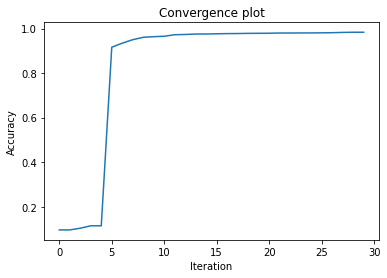

In [ ]:
results = study.trials_dataframe()

results['value'].sort_values().reset_index(drop=True).plot()
plt.title('Convergence plot')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

In [ ]:
results.head()

,number,value,datetime_start,datetime_complete,duration,params_activation0,params_activation1,params_activation2,params_filters_0,params_filters_1,...,params_num_conv_layers,params_num_dense_layers,params_optimizer_name,params_strides0,params_strides1,params_strides2,params_units0,params_units1,params_units2,state
0,0,0.973280,2021-05-20 18:21:58.124679,2021-05-20 18:23:44.991946,0 days 00:01:46.867267,tanh,NaN,NaN,16,NaN,...,1,1,Adam,1,NaN,NaN,389,NaN,NaN,COMPLETE
1,1,0.934392,2021-05-20 18:23:45.104026,2021-05-20 18:30:28.707171,0 days 00:06:43.603145,tanh,tanh,tanh,16,64.0,...,3,2,Adam,1,2.0,1.0,353,297.0,NaN,COMPLETE
2,2,0.096032,2021-05-20 18:30:28.783724,2021-05-20 18:46:56.184767,0 days 00:16:27.401043,relu,relu,tanh,64,16.0,...,3,1,RMSprop,1,1.0,1.0,334,NaN,NaN,COMPLETE
3,3,0.103704,2021-05-20 18:46:56.245810,2021-05-20 19:00:32.438469,0 days 00:13:36.192659,tanh,tanh,NaN,64,32.0,...,2,2,RMSprop,1,1.0,NaN,24,441.0,NaN,COMPLETE
4,4,0.976455,2021-05-20 19:00:32.502514,2021-05-20 19:08:10.338109,0 days 00:07:37.835595,relu,relu,NaN,32,16.0,...,2,1,RMSprop,1,1.0,NaN,255,NaN,NaN,COMPLETE


#### Evaluate the model

In [ ]:
# load best model

model = load_model(path_best_model)

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 14, 14, 32)        832       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 1568)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 492)               771948    
_________________________________________________________________
dense_34 (Dense)             (None, 12)                5916      
_________________________________________________________________
dense_35 (Dense)             (None, 17)                221       
_________________________________________________________________
dense_36 (Dense)             (None, 10)              

In [ ]:
# make predictions in test set

result = model.evaluate(x=X_test,
                        y=y_test)

132/132 [==============================] - 4s 15ms/step - loss: 0.0617 - accuracy: 0.9843


In [ ]:
# print evaluation metrics

for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.06171351298689842
accuracy 0.9842857122421265


#### Confusion matrix

In [ ]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1)

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) 

cm

array([[419,   0,   0,   0,   0,   0,   1,   0,   2,   0],
       [  0, 469,   0,   0,   0,   0,   1,   2,   1,   0],
       [  2,   3, 402,   0,   0,   0,   1,   1,   0,   0],
       [  0,   0,   1, 420,   0,   2,   0,   2,   1,   0],
       [  1,   2,   0,   0, 422,   0,   3,   1,   0,   0],
       [  0,   0,   0,   2,   0, 374,   3,   0,   3,   0],
       [  0,   0,   0,   0,   0,   0, 412,   0,   0,   0],
       [  0,   1,   4,   2,   0,   0,   0, 462,   0,   0],
       [  0,   2,   0,   1,   0,   1,   2,   0, 378,   0],
       [  4,   2,   0,   2,   8,   0,   0,   1,   1, 376]], dtype=int64)

Text(0.5, 13.421126458070283, 'Predicted label')

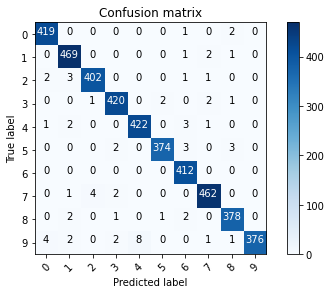

In [ ]:
# let's make it more colourful
classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Here we can see that our CNN performs very well on all digits.

### Search Analysis with Optuna

I will demo the built-in plotting functions from Optuna.

We will use the [matplotlib backend](https://optuna.readthedocs.io/en/stable/reference/visualization/matplotlib.html). Optuna also offers the functions with [plotly backend](https://optuna.readthedocs.io/en/stable/reference/visualization/index.html).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import optuna

##### Load the search results

We created and stored this search in the previous notebook.

In [ ]:
study_name = "cnn_study"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

study = optuna.load_study(
    study_name=study_name,
    storage=storage_name,
)

In [ ]:
study.best_params

{'activation': 'relu',
 'filters': 64,
 'kernel_size': 5,
 'learning_rate': 0.0020539678624769604,
 'num_conv_layers': 3,
 'num_dense_layers': 2,
 'optimizer_name': 'Adam',
 'strides': 2,
 'units': 114}

##### Optimization history

<ipython-input-4-d78f92e513d8>:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


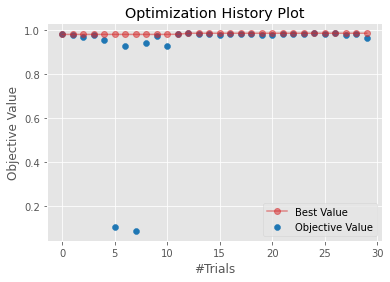

In [ ]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)

##### Contour plot - 2D plots

<ipython-input-5-0ace122e7055>:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(
[W 2021-05-20 20:09:37,226] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


array([[<AxesSubplot:ylabel='num_conv_layers'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='num_dense_layers'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='optimizer_name'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='num_conv_layers', ylabel='units'>,
        <AxesSubplot:xlabel='num_dense_layers'>,
        <AxesSubplot:xlabel='optimizer_name'>,
        <AxesSubplot:xlabel='units'>]], dtype=object)

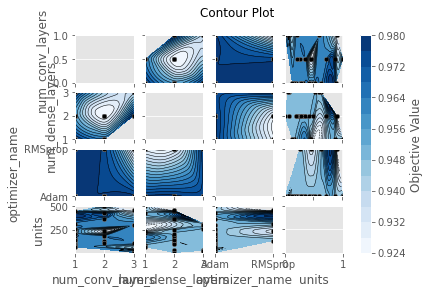

In [ ]:
optuna.visualization.matplotlib.plot_contour(
    study,
    params=["num_conv_layers", "num_dense_layers", "optimizer_name", 'units'],
)

##### Plot slice

<ipython-input-6-2a5504aa5d67>:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(


array([<AxesSubplot:xlabel='num_conv_layers', ylabel='Objective Value'>,
       <AxesSubplot:xlabel='num_dense_layers'>,
       <AxesSubplot:xlabel='optimizer_name'>,
       <AxesSubplot:xlabel='units'>], dtype=object)

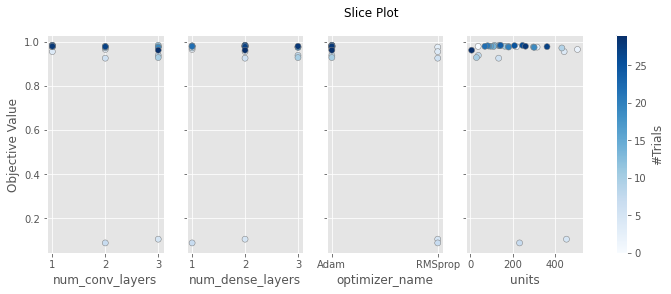

In [ ]:
optuna.visualization.matplotlib.plot_slice(
    study,
    params=["num_conv_layers", "num_dense_layers", "optimizer_name", 'units'],
)

##### Parameter importance

fAnova by default but there are other methods. More details [here](https://optuna.readthedocs.io/en/stable/reference/importance.html)

<ipython-input-7-a5c7740d20da>:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

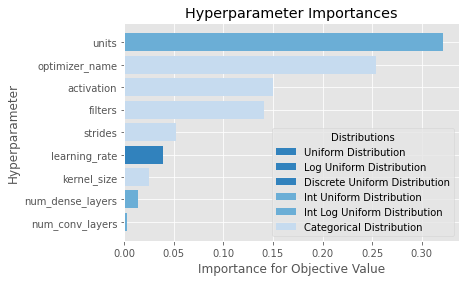

In [ ]:
optuna.visualization.matplotlib.plot_param_importances(study)

##### Plot parallel coordinate

Plots the high dimensional space of the search. In plain English, the feature combinations.

<ipython-input-8-861f853ed763>:1: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(


<AxesSubplot:title={'center':'Parallel Coordinate Plot'}>

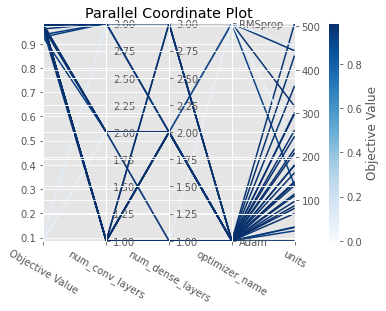

In [ ]:
optuna.visualization.matplotlib.plot_parallel_coordinate(   
    study,
    params=["num_conv_layers", "num_dense_layers", "optimizer_name", 'units'],
)

##### Compare 2 or more searches

<ipython-input-9-93837a46823f>:1: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_edf([study])


<AxesSubplot:title={'center':'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

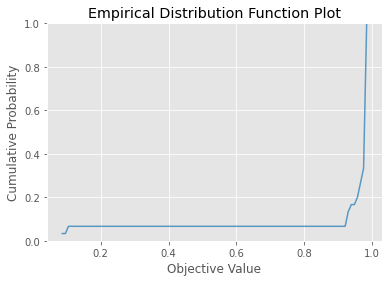

In [ ]:
optuna.visualization.matplotlib.plot_edf([study])

<ipython-input-10-6ecd3dc3bddd>:9: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_edf([study, study2])


<AxesSubplot:title={'center':'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

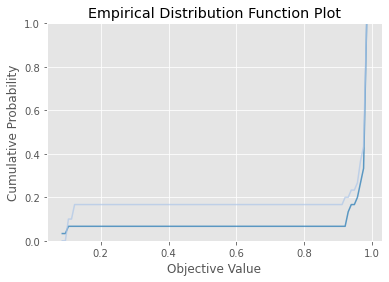

In [ ]:
study_name2 = "cnn_study_2"
storage_name2 = "sqlite:///{}.db".format(study_name2)

study2 = optuna.load_study(
    study_name=study_name2,
    storage=storage_name2,
)

optuna.visualization.matplotlib.plot_edf([study, study2])

##### More examples of visualizations

https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html#